In [5]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/Merijn68/BondTrading.git    
    %pip install -q "ray[tune]" bayesian-optimization
    %pip install loguru tensorflow-addons

# Base model

In eerste instantie wordt een naive voorspelling gemaakt voor de bond markt. Het doel hiervan is om een benchmark te hebben waarmee de andere modellen kunnen worden vergeleken. We voorspellen voor 1 bond voor 10 dagen vooruit wat de bond prijs gaat doen. Idealiter zouden we de prijsontwikkeling van meerdere (alle) staatsobligaties tegelijk willen voorspellen, zodat het model op 1 moment kan aangeven welke bond een betere investering zou zijn. Maar 1 stap tegelijk.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import matplotlib.pyplot as plt
sys.path.insert(0, "..")
from src.data import make_dataset
from src.models import window, evaluate, base_model, hyper
from pathlib import Path
datadir = Path("../data/raw")

import tensorflow as tf
import numpy as np

In [2]:
df_price = make_dataset.read_pkl('price', path = Path("data/processed/"))
isin = "DE0001102374" # 10 Years NL Bond, maturity 2025 0.5% coupon
df_isin = df_price[df_price['reference_identifier'] == isin]
# Subset only 2 years for training
df_isin = df_isin[df_isin['rate_dt'] > '1-jan-2020']
df_isin = df_isin.set_index('rate_dt')
df_isin = df_isin.sort_index()

2022-01-15 11:04:11.639 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed price data


<AxesSubplot:xlabel='rate_dt'>

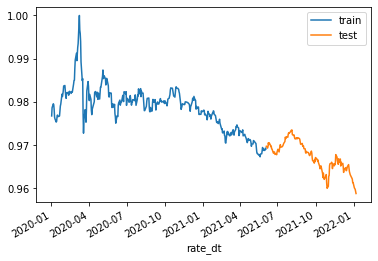

In [3]:
series = df_isin['mid']
split = math.floor(len(series) * .70)

# Train test split
train = series[:split]
norm = max(train)
test = series[split:]
train = train / norm
test = test / norm
train.plot(label = "train",legend=True)
test.plot(label ="test",legend=True)

In [9]:
(train.shape, test.shape)

((364,), (156,))

In [10]:
# Create a windowed dataset from the data
window_size = 32 
batch_size = 32
shuffle_buffer = 2
horizon = 10
train_set = window.windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = window.windowed_dataset(test, window_size, batch_size, shuffle_buffer, horizon=horizon)

In [6]:
x, y = next(iter(train_set))
x.shape, y.shape

(TensorShape([32, 32]), TensorShape([32, 10]))

In [9]:
# This needs to move somewhere else...

maelist = []
for x, y in train_set:      
    x = x[:, -1] # get the last value of every batch
    size = tf.size(x) # this will be the batchsize, so mostly 32
    yhat = tf.broadcast_to(tf.reshape(x, [size,1]), [size, horizon]) # broadcast
    mae = np.mean(np.abs(yhat - y)) # calculate mae
    maelist.append(mae)
norm = np.mean(maelist)
print(norm)
smae = evaluate.ScaledMAE(scale=norm)


0.0017946863538154426


In [10]:
# 1 step naive prediction
y, yhat = base_model.naivepredict(train.values)
norm = evaluate.mae(y, yhat)
norm, evaluate.mse(y, yhat), evaluate.mase(y, yhat)

(0.0008037090185018606, 1.4763744497803104e-06, 1.0037629125887806)

Een eenvoudig referentie model

In [11]:
%load_ext tensorboard

In [12]:
result = {}

In [13]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as tfl
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model = Sequential([    
        tfl.Reshape((window_size, 1)),
        tfl.SimpleRNN(1),
        tfl.Dense(horizon)
    ])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)


In [14]:

for lr in [1e-2, 1e-3, 1e-4]:
    name = f"simpleRNN_Adam{lr}"
    logdir = Path("logs") / name
    tb = TensorBoard(logdir, histogram_freq=1)    
    model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=["mae", smae])
    result[name] = model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop, tb], verbose=0)
    print('lr:', lr, model.evaluate(valid_set))

4/4 [==============================] - 0s 30ms/step - loss: 7.7586e-05 - mae: 0.0083 - smae: 4.6514
lr: 0.01 [7.758554420433939e-05, 0.008347850292921066, 4.651426792144775]
4/4 [==============================] - 0s 31ms/step - loss: 3.8931e-05 - mae: 0.0053 - smae: 2.9381
lr: 0.001 [3.8931106246309355e-05, 0.0052730427123606205, 2.9381420612335205]
4/4 [==============================] - 0s 30ms/step - loss: 6.1184e-05 - mae: 0.0071 - smae: 3.9493
lr: 0.0001 [6.118353485362604e-05, 0.0070878248661756516, 3.949338912963867]


In [16]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 1888), started 16:43:22 ago. (Use '!kill 1888' to kill it.)

Het blijkt moeilijk om de naive voorspelling te verbeteren. Een hogere learning rate is zeker in het begin nodig. Na max 10 epochs is het model dan ook wel uitgeleerd en kunnen we waarschijnlijk beter met een lagere learning rate verder gaan.

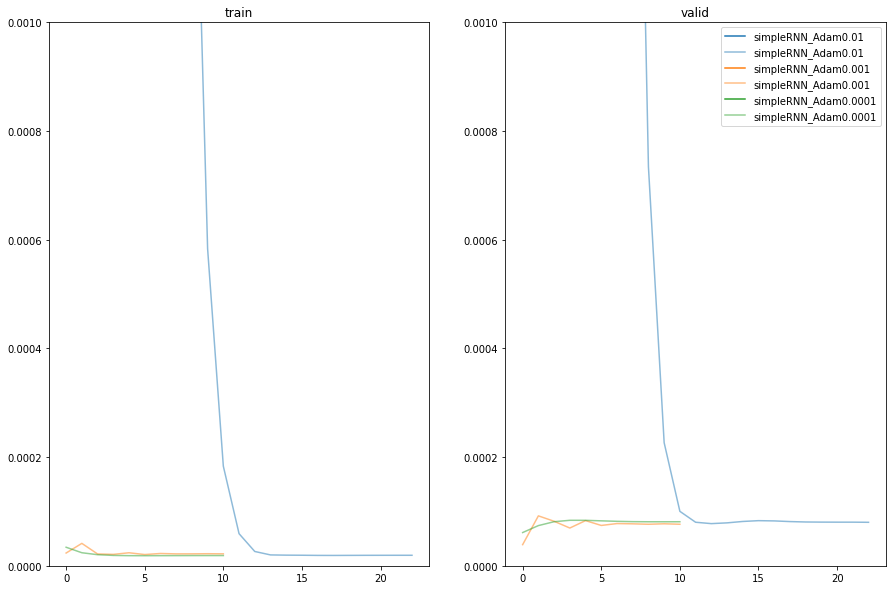

In [20]:
from src.models import evaluate
evaluate.plot_results(result, ymax = 0.001, subset="simple")

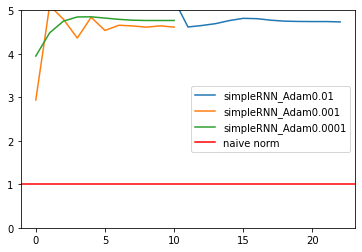

In [22]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=5.0, subset="simple")

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

name = f"simpleRNN_Adam_rlr"
logdir = Path("logs") / name
tb = TensorBoard(logdir, histogram_freq=1)
lr = 0.01

reduce_lr = ReduceLROnPlateau(monitor='smae', factor=0.5,
                              patience=3, min_lr=1e-5)
model.compile(loss="mse", optimizer=Adam(learning_rate = lr), metrics=["mae", smae])                              
result[name] = model.fit(train_set, epochs=200, validation_data=valid_set, callbacks=[reduce_lr, early_stop, tb], verbose=0)

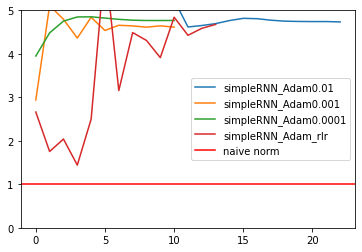

In [24]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=5.0, subset="simple")

Ook wanneer we de learning rate reduceren wordt het model niet veek beter. De modellen lijken eerder slechter te gaan presteren wanneer we deze trainen dan beter.

Uitbreiden van het model

In [25]:
opt = tf.keras.optimizers.get('Adam')
opt.learning_rate = 0.1
opt.get_config()

{'name': 'Adam',
 'learning_rate': 0.1,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [26]:
from src.models import hyper
from tqdm import tqdm

config = {
    'window'    :   32,
    'filters'   :   16,
    'kernel'    :   4,    
    'units'     :   16,    
    'hidden'    :   1, 
    'horizon'   :   horizon,
    'type'      :   'RNN'    
}

for key in tqdm(["Adam", "SGD", "RMSprop"]):
    early_stop = EarlyStopping(patience=15, restore_best_weights=True)

    name = f"16_RNN_{key}"
    logdir = Path("logs") / name
    tb = TensorBoard(logdir, histogram_freq=1)
    
    opt = tf.keras.optimizers.get(key)
    opt.momentum = 0.9
    opt.learning_rate = 0.01

    model = hyper.HyperRnn(config)
    model.compile(loss="mse",
          optimizer=opt,
          metrics=["mae", "mape", smae])

    result[name] = model.fit(train_set,epochs=200,callbacks=[tb, early_stop, reduce_lr],
                            validation_data=valid_set, verbose=0)
    print('opt:', key, model.evaluate(valid_set))

  0%|          | 0/3 [00:00<?, ?it/s]

4/4 [==============================] - 0s 30ms/step - loss: 5.2432e-05 - mae: 0.0060 - mape: 0.6193 - smae: 3.3333


 33%|███▎      | 1/3 [00:35<01:11, 35.89s/it]

opt: Adam [5.243249688646756e-05, 0.005982142873108387, 0.6193292737007141, 3.3332529067993164]
4/4 [==============================] - 0s 34ms/step - loss: 7.4052e-05 - mae: 0.0077 - mape: 0.7954 - smae: 4.2794


 67%|██████▋   | 2/3 [01:45<00:55, 55.54s/it]

opt: SGD [7.405154610751197e-05, 0.007680258248001337, 0.7954328060150146, 4.279443264007568]
4/4 [==============================] - 0s 32ms/step - loss: 1.1484e-05 - mae: 0.0028 - mape: 0.2926 - smae: 1.5745


100%|██████████| 3/3 [02:33<00:00, 51.15s/it]

opt: RMSprop [1.1484088645374868e-05, 0.0028257854282855988, 0.2925952970981598, 1.5745289325714111]


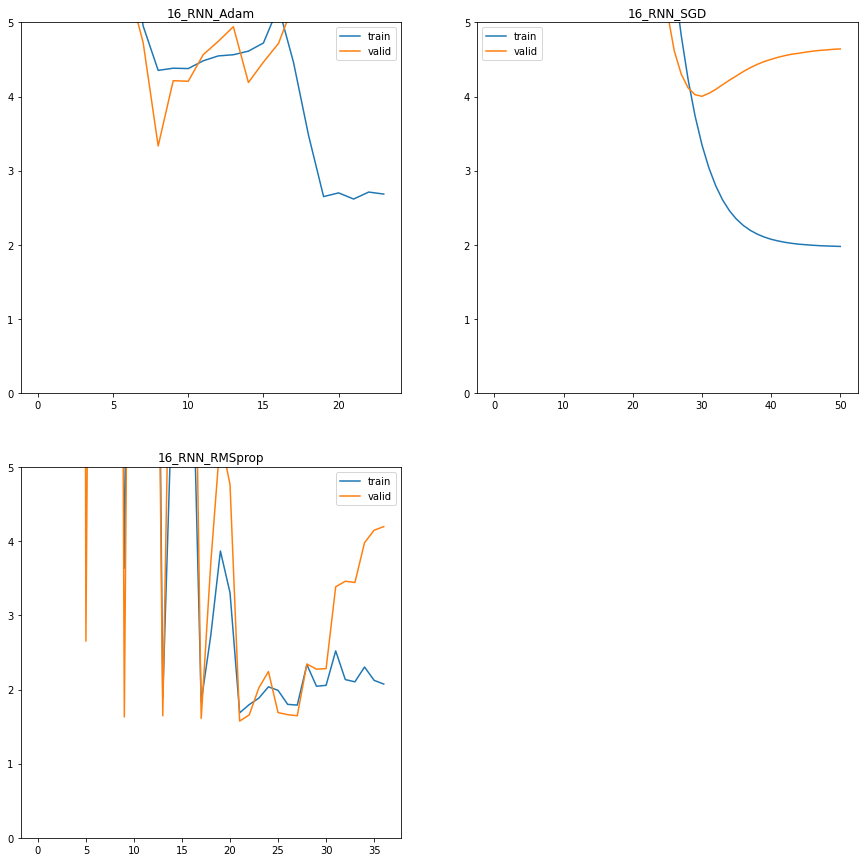

In [27]:
evaluate.plot_results(result, ymax = 5, subset="16",grid = True, measure = 'smae')

Het wordt er niet beter op. RMSprop lijkt iets beter te leren. Opvallend verder dat de modellen het allemaal beter doen op de validatie set dan op de training set.

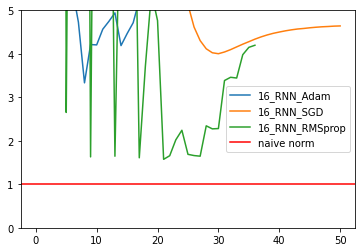

In [28]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=5.0, subset="16")

Deeper models with memory...

In [29]:
reduce_lr = ReduceLROnPlateau(monitor='smae', factor=0.5,
                              patience=3, min_lr=1e-5)

config = {
    "window" : window_size,
    "filters" : 64,
    "kernel" : 3,
    "type" : "GRU",
    "units" : 128,
    "hidden" : 4,
    "horizon" : horizon,
}

for key in tqdm(["Adam", "SGD", "RMSprop"]):
    early_stop = EarlyStopping(patience=15, restore_best_weights=True)

    name = f"GRU_{key}"
    logdir = Path("logs") / name
    tb = TensorBoard(logdir, histogram_freq=1)

    opt = tf.keras.optimizers.get(key)
    opt.momentum = 0.9
    opt.learning_rate = 0.01

    model = hyper.HyperRnn(config)
    model.compile(loss="mse",
          optimizer=opt,
          metrics=["mae", "mape", smae])
    
    result[name] = model.fit(train_set,epochs=200,callbacks=[tb, early_stop, reduce_lr],
                            validation_data=valid_set, verbose=0)
    print('opt:', key, model.evaluate(valid_set))

  0%|          | 0/3 [00:00<?, ?it/s]

4/4 [==============================] - 0s 21ms/step - loss: 3.5426e-06 - mae: 0.0014 - mape: 0.1498 - smae: 0.8065


 33%|███▎      | 1/3 [00:11<00:22, 11.47s/it]

opt: Adam [3.5426076010480756e-06, 0.0014474696945399046, 0.14979223906993866, 0.806530773639679]
4/4 [==============================] - 0s 19ms/step - loss: 3.0489e-05 - mae: 0.0046 - mape: 0.4809 - smae: 2.5873


 67%|██████▋   | 2/3 [00:23<00:11, 11.82s/it]

opt: SGD [3.0488821721519344e-05, 0.004643326159566641, 0.4808991849422455, 2.587263584136963]
4/4 [==============================] - 0s 20ms/step - loss: 1.2771e-05 - mae: 0.0030 - mape: 0.3078 - smae: 1.6572


100%|██████████| 3/3 [00:32<00:00, 10.98s/it]

opt: RMSprop [1.2771431102009956e-05, 0.0029741458129137754, 0.3078182339668274, 1.6571950912475586]


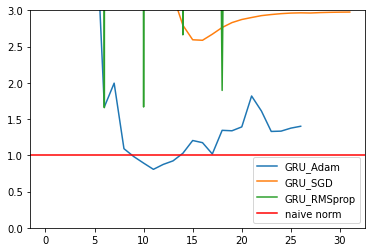

In [30]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=3.0, subset="GRU")

Modellen met historie doen het aanzienlijk beter - zoals verwacht. De RMSprop optimizer lijkt het nu juist weer een stuk minder goed te doen.

In [4]:
# Hypertune

from ray import tune
config = {
    "datadir" : Path("data").absolute(),
    "grace_period" : 3,
    "local_dir" : "logs",
    "epochs" : 20,
    "samples" : 25,
    "window" : tune.randint(16, 52),
    "filters" : tune.randint(8, 32),
    "kernel" : 3,
    "type" : tune.choice(["GRU", "LSTM"]),
    "optimizer" : tune.choice(["Adam", "RMSprop"]),
    "hidden" : tune.randint(1, 5),
    "units" : tune.qrandint(64, 256, 16),
    "horizon" : 10,
}

In [6]:
analysis = hyper.hypertune(train, test, config)

Trial name,status,loc,filters,hidden,optimizer,type,units,window,iter,total time (s),val_loss,val_mae
wrapper_df70c_00007,RUNNING,127.0.0.1:2260,17,1,RMSprop,GRU,128,38,5,13.4727,0.000419836,0.0186529
wrapper_df70c_00008,PENDING,,18,1,RMSprop,GRU,256,32,,,,
wrapper_df70c_00009,PENDING,,27,2,RMSprop,LSTM,64,36,,,,
wrapper_df70c_00010,PENDING,,23,1,RMSprop,GRU,256,21,,,,
wrapper_df70c_00011,PENDING,,27,2,RMSprop,GRU,256,39,,,,
wrapper_df70c_00012,PENDING,,28,2,Adam,LSTM,176,29,,,,
wrapper_df70c_00013,PENDING,,15,2,Adam,LSTM,192,41,,,,
wrapper_df70c_00014,PENDING,,20,3,Adam,LSTM,64,41,,,,
wrapper_df70c_00015,PENDING,,24,3,Adam,GRU,256,27,,,,
wrapper_df70c_00016,PENDING,,14,2,Adam,LSTM,144,17,,,,


 pid=2260) citFunc
 pid=2260) 11/11 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0302 - val_loss: 4.1984e-04 - val_mae: 0.0187 - lr: 0.0010
 pid=2260) Epoch 6/20
 pid=2260) citFunc
 pid=2260)  1/11 [=>............................] - ETA: 0s - loss: 3.7217e-04 - mae: 0.0171
 pid=2260) citFunc
 pid=2260)  5/11 [============>.................] - ETA: 0s - loss: 5.4925e-04 - mae: 0.0196
 pid=2260) 10/11 [==========================>...] - ETA: 0s - loss: 4.4066e-04 - mae: 0.0170
 pid=2260) citFunc
 pid=2260) 11/11 [==============================] - 0s 18ms/step - loss: 4.3487e-04 - mae: 0.0169 - val_loss: 1.3155e-04 - val_mae: 0.0095 - lr: 9.0484e-04
 pid=2260) Epoch 7/20
 pid=2260) citFunc
 pid=2260)  1/11 [=>............................] - ETA: 0s - loss: 2.2093e-04 - mae: 0.0120
 pid=2260) citFunc
 pid=2260)  6/11 [===============>..............] - ETA: 0s - loss: 2.2314e-04 - mae: 0.0125
 pid=2260) 11/11 [==============================] - ETA: 0s - loss: 1.571

2022-01-15 11:45:45,409	WARNING tune.py:582 -- SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to skip. 


In [ ]:
config = analysis.get_best_config()
config

In [ ]:
window_size = config["window"]
horizon = config["horizon"]
train_set = make_dataset.windowed_dataset(
    train, window_size, batch_size=32, shuffle_buffer=25, horizon=horizon
)
valid_set = make_dataset.windowed_dataset(
    train, window_size, batch_size=32, shuffle_buffer=25, horizon=horizon
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5
)
opt = tf.keras.optimizers.get(config["optimizer"])
opt.momentum = 0.9
opt.learning_rate = 0.01
model = hyper.HyperRnn(config)
model.compile(loss="mse", optimizer=opt, metrics=["mae", "mape", smae])

result["hypertuned"] = model.fit(
        train_set,
        epochs=150,
        validation_data=valid_set,
        callbacks=[reduce_lr, early_stop],
    )


In [ ]:
plt.figure(figsize=(8,8))
evaluate.naive(result, ylim=1.5)

In [ ]:
evaluate.plot_results(result, ymax = 0.1)

In [ ]:
pred = evaluate.generate_prediction(model, test, window = window_size, horizon = horizon)

In [ ]:
pred = evaluate.generate_prediction(model, test, window = window_size, horizon = 4)